# Урок 2. CNN and LSTM for human action recognition

ЗАДАНИЕ 1. Необходимо нормализовать данные в датасете: написать функцию
нормализации и использовать ее внутри класса датасета.

ЗАДАНИЕ 2. Приложен ноутбук в котором генерируется из большого датасета меньшая его
копия. Вам нужно:
a. Сгенерировать меньший датасет из 8-10 классов движения
b. Изменить функцию разбиения датасета на тестовую и тренировочную
часть, увеличив кусок, отводимый на тест
c. Обучить уже существующую модель (предварительно проанализировав
какие параметры нужно менять)
d. Изменить модель для улучшения качества
e. Сгенерировать другой датасет с меньшим количеством “кадром” в нашей
серии и сравнить с улучшилось или ухудшилось качество предсказания.
Провести несколько таких итераций, дать свою оценку уменьшению
кадров, назвать оптимальное, на ваш взгляд, их количество.

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd

use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [2]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
#         self.dr = torch.nn.Dropout2d(0.25)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def normalize(item):
    for row in item:
        for i in np.arange(len(row)):
            row[i]= sigmoid(row[i])            
    return item    
 

In [4]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, frames_count=45,transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.frames_count=frames_count


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(self.frames_count,75)
        label = self.data.iloc[idx,-1]
        
        if self.transform != None:
            item = self.transform(item)

        return (item, label) 

In [5]:
LABELS = {0: "sitting down", 1: "clapping", 2: "take off a shoe", 3: "take off a hat/cap", 4: "cheer up", 5: "hand waving",  6: "jump up", 7:"make a phone call/answer phone"}

In [6]:
dataset = Skeleton_Dataset(file_path = "test_01.csv", transform=normalize)

In [7]:
skel, lab = dataset.__getitem__(41)
print(type(skel))
print(LABELS[lab])
print(skel.shape)

<class 'numpy.ndarray'>
jump up
(45, 75)


In [8]:
[len(dataset),int(0.7*len(dataset)),int(0.3*len(dataset))]

[1112, 778, 333]

In [9]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.7*len(dataset)),int(0.3*len(dataset))+1])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [10]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=8, bias=True)
)

In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
sket_tensor = torch.from_numpy(skel).unsqueeze(0).float()
print(sket_tensor.size())
output = rnn(sket_tensor.to(device))
output.topk(5)

torch.Size([1, 45, 75])


torch.return_types.topk(
values=tensor([[ 0.0544,  0.0306,  0.0068, -0.0129, -0.0226]], grad_fn=<TopkBackward>),
indices=tensor([[3, 7, 6, 4, 0]]))

In [13]:
from torch import optim
import time
import math
%matplotlib notebook

In [31]:
def train_model(criterion,learning_rate,optimizer,rnn_net,train_loader,epochs=800):
    all_losses = []
    start = time.time()
    counter = 0
    for epoch in range(epochs):  
        current_loss = 0
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
        
            inputs, labels = data[0].to(device), data[1].to(device)
    
            optimizer.zero_grad()
    
            output = rnn_net(inputs.float())
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step() 

            current_loss += loss.item()
            category = LABELS[int(labels[0])]

            if counter % 500 == 0:
                guess, guess_i = categoryFromOutput(output)
                correct = '✓' if guess == category else '✗ (%s)' % category
                print('epoch : %d iter : %d (%s) %.4f  предсказанное значение: %s %s' % (epoch, i, timeSince(start), loss, guess, correct))
            
        
            counter = counter + 1
        if counter % 100 == 0:
            all_losses.append(current_loss / 25)
            current_loss = 0
            #plt.plot(list(range(0,len(all_losses))),all_losses)
            #plt.show()
    return rnn_net,all_losses
    

In [15]:
def get_accuracy(test_loader,rnn_net):
    total = 0
    right = 0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            counter = counter + 1
            inputs, labels = data[0].to(device), data[1].to(device)   
            output = rnn_net(inputs.float())
            guess, guess_i = categoryFromOutput(output)
            category = LABELS[int(labels[0])]
        
            if guess == category:
                right = right + 1
    print('Accuracy of the network:  ',  (100 * right / counter))

In [16]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)
epochs=200

In [18]:
rnn_net,all_losses=train_model(criterion, learning_rate, optimizer, rnn, train_loader,epochs)

epoch : 0 iter : 0 (0m 0s) 2.0744  предсказанное значение: take off a hat/cap ✗ (take off a shoe)
epoch : 10 iter : 10 (2m 6s) 2.1073  предсказанное значение: cheer up ✓
epoch : 20 iter : 20 (4m 13s) 1.6146  предсказанное значение: make a phone call/answer phone ✗ (hand waving)
epoch : 30 iter : 30 (6m 19s) 2.1055  предсказанное значение: take off a shoe ✗ (hand waving)
epoch : 40 iter : 40 (8m 25s) 1.5627  предсказанное значение: hand waving ✓
epoch : 51 iter : 1 (10m 35s) 1.7393  предсказанное значение: sitting down ✗ (jump up)
epoch : 61 iter : 11 (12m 46s) 1.2177  предсказанное значение: jump up ✓
epoch : 71 iter : 21 (14m 57s) 0.8618  предсказанное значение: hand waving ✓
epoch : 81 iter : 31 (17m 9s) 0.8162  предсказанное значение: jump up ✗ (take off a shoe)
epoch : 91 iter : 41 (19m 28s) 0.9536  предсказанное значение: make a phone call/answer phone ✓


<IPython.core.display.Javascript object>

epoch : 102 iter : 2 (21m 46s) 1.1178  предсказанное значение: make a phone call/answer phone ✓
epoch : 112 iter : 12 (24m 6s) 0.9182  предсказанное значение: cheer up ✓
epoch : 122 iter : 22 (26m 26s) 0.9451  предсказанное значение: take off a shoe ✓
epoch : 132 iter : 32 (28m 48s) 1.0606  предсказанное значение: sitting down ✓
epoch : 142 iter : 42 (31m 8s) 0.7153  предсказанное значение: clapping ✓
epoch : 153 iter : 3 (33m 31s) 0.8055  предсказанное значение: cheer up ✓
epoch : 163 iter : 13 (35m 58s) 1.6386  предсказанное значение: sitting down ✗ (hand waving)
epoch : 173 iter : 23 (38m 23s) 1.6703  предсказанное значение: cheer up ✓
epoch : 183 iter : 33 (40m 46s) 0.9358  предсказанное значение: clapping ✗ (take off a hat/cap)
epoch : 193 iter : 43 (43m 6s) 1.0230  предсказанное значение: jump up ✓


<IPython.core.display.Javascript object>


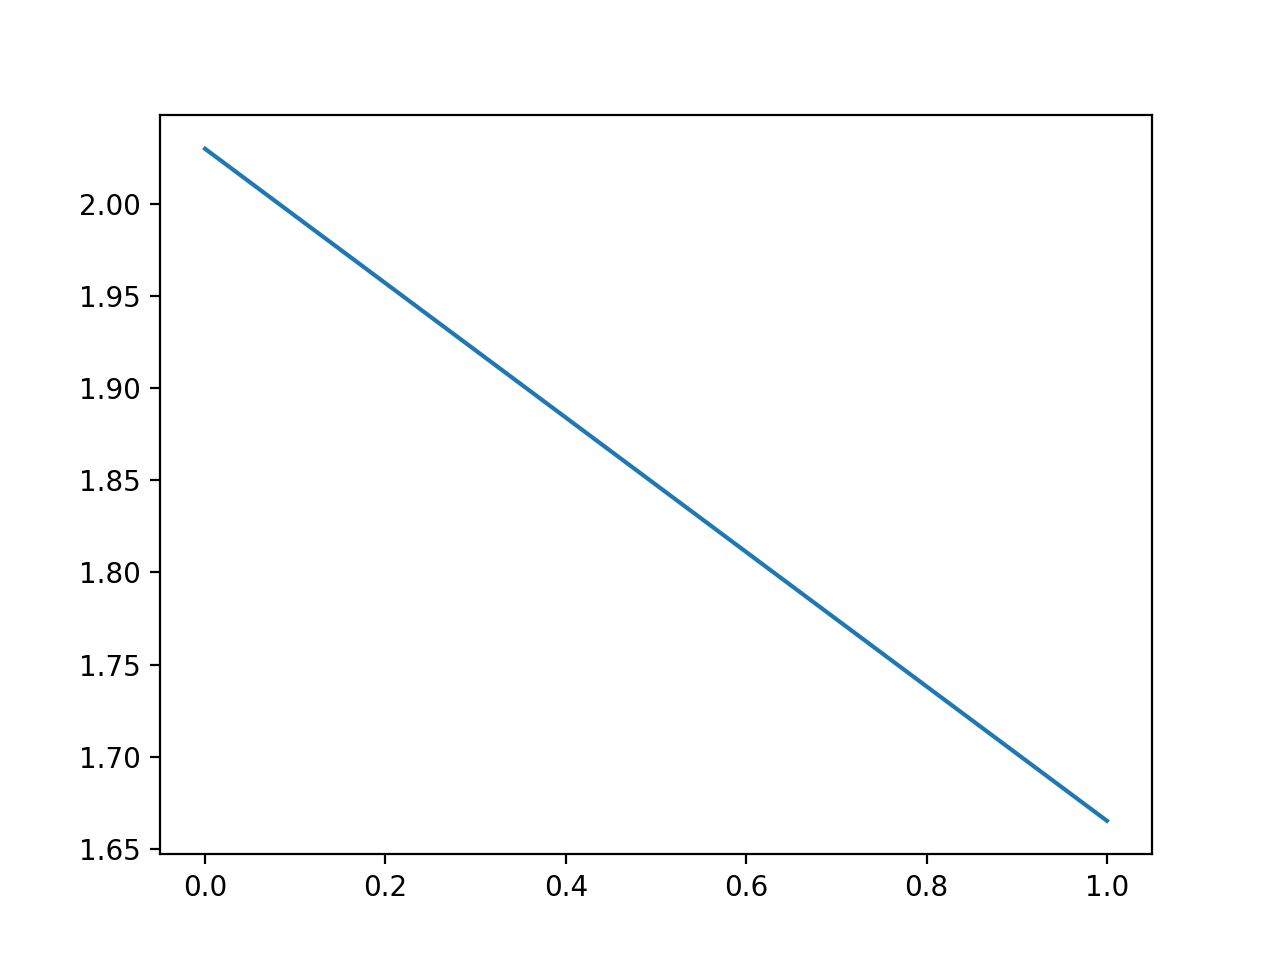

In [21]:
%matplotlib notebook
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [20]:
get_accuracy(test_loader,rnn_net)

Accuracy of the network:   61.904761904761905


In [22]:
n_layer = 4
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)
learning_rate = 0.003
optimizer = optim.Adagrad(rnn.parameters(),lr=learning_rate)
epochs=300

epoch : 0 iter : 0 (0m 0s) 2.1060  предсказанное значение: take off a hat/cap ✓
epoch : 10 iter : 10 (2m 31s) 1.8290  предсказанное значение: take off a shoe ✗ (sitting down)
epoch : 20 iter : 20 (5m 11s) 1.2603  предсказанное значение: make a phone call/answer phone ✗ (clapping)
epoch : 30 iter : 30 (7m 55s) 1.3280  предсказанное значение: sitting down ✗ (take off a hat/cap)
epoch : 40 iter : 40 (10m 40s) 1.3592  предсказанное значение: sitting down ✗ (jump up)
epoch : 51 iter : 1 (13m 23s) 0.5055  предсказанное значение: take off a hat/cap ✓
epoch : 61 iter : 11 (15m 59s) 0.8095  предсказанное значение: clapping ✓
epoch : 71 iter : 21 (18m 33s) 0.7448  предсказанное значение: hand waving ✗ (take off a hat/cap)
epoch : 81 iter : 31 (21m 6s) 0.5610  предсказанное значение: hand waving ✗ (clapping)
epoch : 91 iter : 41 (23m 36s) 0.3958  предсказанное значение: make a phone call/answer phone ✓


<IPython.core.display.Javascript object>


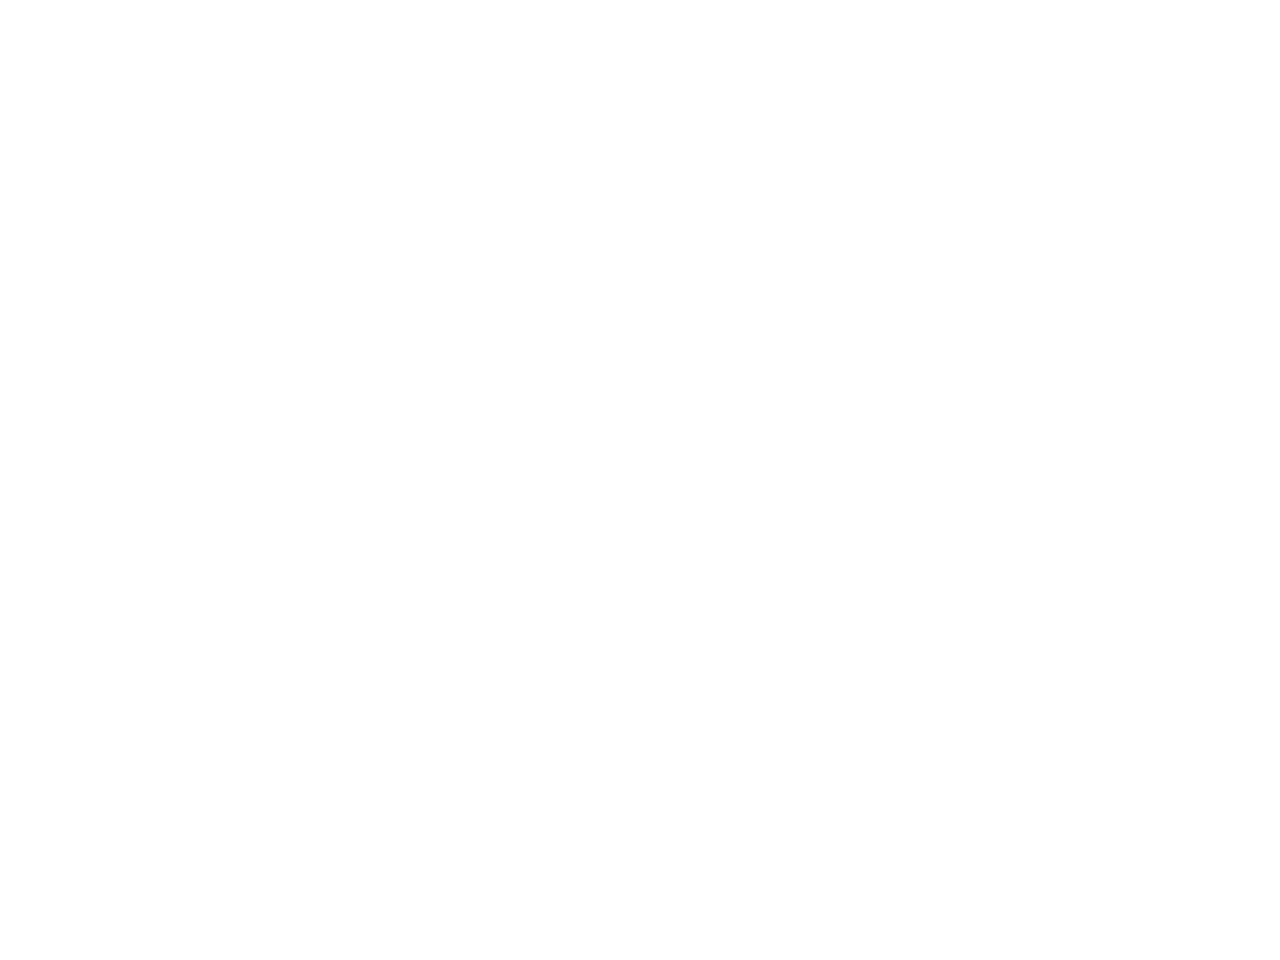

epoch : 102 iter : 2 (26m 5s) 0.5419  предсказанное значение: take off a shoe ✗ (sitting down)
epoch : 112 iter : 12 (28m 33s) 0.3957  предсказанное значение: sitting down ✓
epoch : 122 iter : 22 (31m 1s) 0.5439  предсказанное значение: sitting down ✓
epoch : 132 iter : 32 (33m 27s) 0.5657  предсказанное значение: make a phone call/answer phone ✓
epoch : 142 iter : 42 (35m 53s) 0.7250  предсказанное значение: cheer up ✓
epoch : 153 iter : 3 (38m 19s) 0.4183  предсказанное значение: cheer up ✓
epoch : 163 iter : 13 (40m 46s) 0.8369  предсказанное значение: take off a hat/cap ✓
epoch : 173 iter : 23 (43m 12s) 0.2483  предсказанное значение: jump up ✓
epoch : 183 iter : 33 (45m 38s) 0.2144  предсказанное значение: sitting down ✓
epoch : 193 iter : 43 (48m 4s) 0.4824  предсказанное значение: make a phone call/answer phone ✓
epoch : 204 iter : 4 (50m 30s) 0.3743  предсказанное значение: sitting down ✓
epoch : 214 iter : 14 (52m 57s) 0.2827  предсказанное значение: take off a hat/cap ✓
epoch

In [23]:
rnn_net,all_losses=train_model(criterion, learning_rate, optimizer, rnn, train_loader,epochs)

<IPython.core.display.Javascript object>


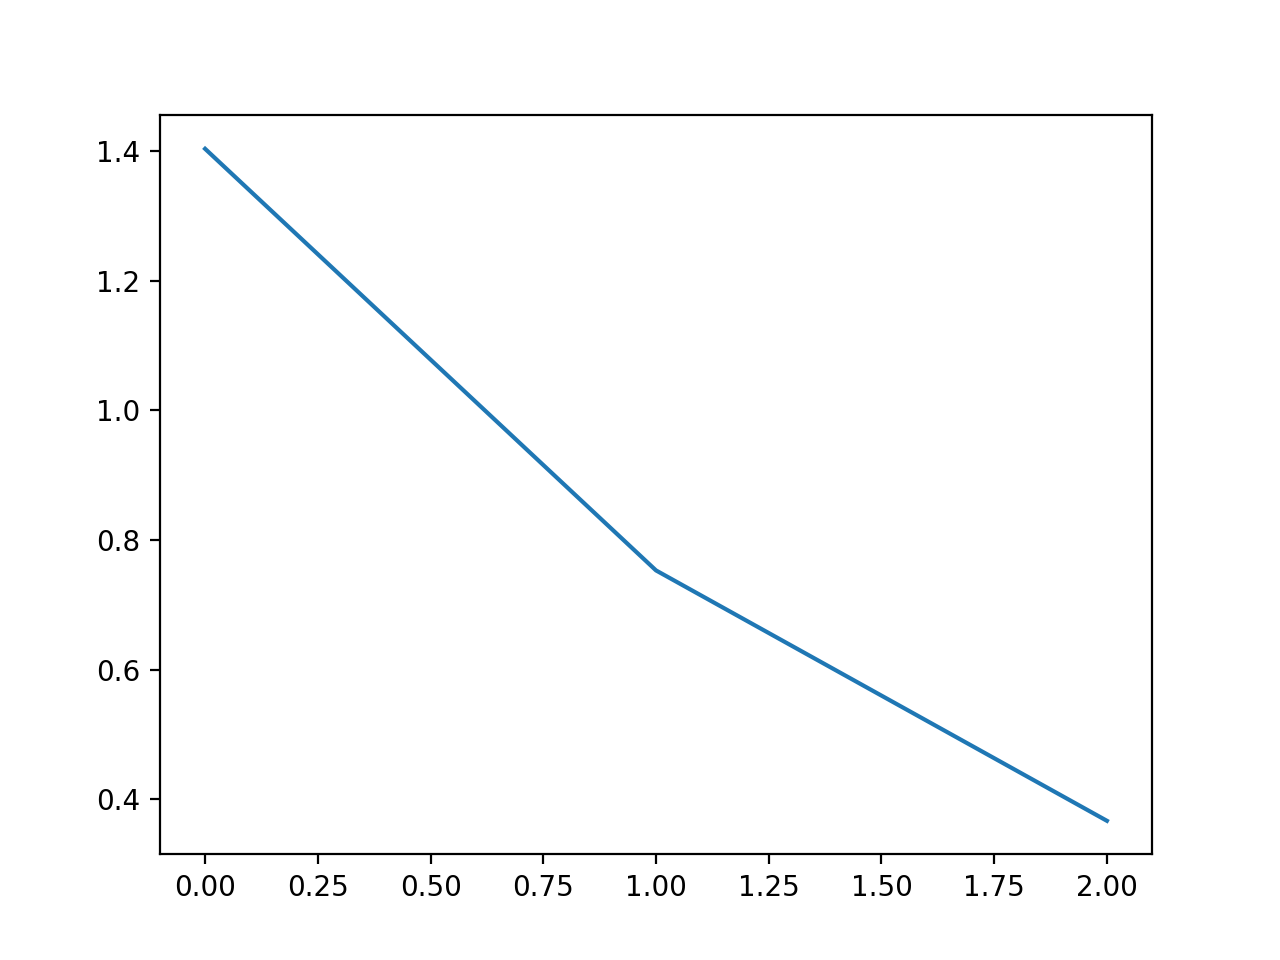

In [28]:
%matplotlib notebook
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [29]:
get_accuracy(test_loader,rnn_net)

Accuracy of the network:   76.19047619047619


**Изменить модель для улучшения качества - Вывод: качество улучшилось, что отразилось на точности, а именно: точность модели повысилась с 61.9 до 76.2 при уменьшении learning_rate до 0.003, увеличении n_layer до 4 и эпох до 300 и изменении оптимайзера на Adagrad**

e. Сгенерировать другой датасет с меньшим количеством “кадром” в нашей
серии и сравнить с улучшилось или ухудшилось качество предсказания.
Провести несколько таких итераций, дать свою оценку уменьшению
кадров, назвать оптимальное, на ваш взгляд, их количество.

1. число кадров=30

In [38]:
dataset = Skeleton_Dataset(file_path = "test_02_30.csv", frames_count=30, transform=normalize)

In [39]:
[len(dataset),int(0.7*len(dataset)),int(0.3*len(dataset))]

[1213, 849, 363]

In [40]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.7*len(dataset)),int(0.3*len(dataset))+1])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [41]:
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=8, bias=True)
)

In [42]:
skel, lab = dataset.__getitem__(41)
print(type(skel))
print(LABELS[lab])
print(skel.shape)

<class 'numpy.ndarray'>
sitting down
(30, 75)


In [43]:
sket_tensor = torch.from_numpy(skel).unsqueeze(0).float()
print(sket_tensor.size())
output = rnn(sket_tensor.to(device))
output.topk(5)

torch.Size([1, 30, 75])


torch.return_types.topk(
values=tensor([[0.1104, 0.0816, 0.0429, 0.0213, 0.0152]], grad_fn=<TopkBackward>),
indices=tensor([[1, 7, 5, 0, 2]]))

In [45]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)
epochs=200

In [46]:
rnn_net,all_losses=train_model(criterion, learning_rate, optimizer, rnn, train_loader,epochs)

epoch : 0 iter : 0 (0m 0s) 2.0807  предсказанное значение: clapping ✗ (sitting down)
epoch : 9 iter : 14 (1m 28s) 2.0739  предсказанное значение: clapping ✗ (jump up)
epoch : 18 iter : 28 (2m 58s) 1.9943  предсказанное значение: clapping ✗ (take off a hat/cap)
epoch : 27 iter : 42 (4m 32s) 1.7669  предсказанное значение: jump up ✗ (hand waving)
epoch : 37 iter : 2 (6m 9s) 1.7209  предсказанное значение: make a phone call/answer phone ✗ (hand waving)
epoch : 46 iter : 16 (7m 47s) 1.5072  предсказанное значение: take off a shoe ✓
epoch : 55 iter : 30 (9m 24s) 1.3456  предсказанное значение: jump up ✓
epoch : 64 iter : 44 (10m 59s) 1.9924  предсказанное значение: cheer up ✓
epoch : 74 iter : 4 (12m 37s) 1.6454  предсказанное значение: clapping ✓
epoch : 83 iter : 18 (14m 13s) 1.6861  предсказанное значение: jump up ✗ (sitting down)
epoch : 92 iter : 32 (15m 50s) 1.4198  предсказанное значение: cheer up ✓
epoch : 101 iter : 46 (17m 27s) 1.4670  предсказанное значение: jump up ✗ (make a pho

<IPython.core.display.Javascript object>


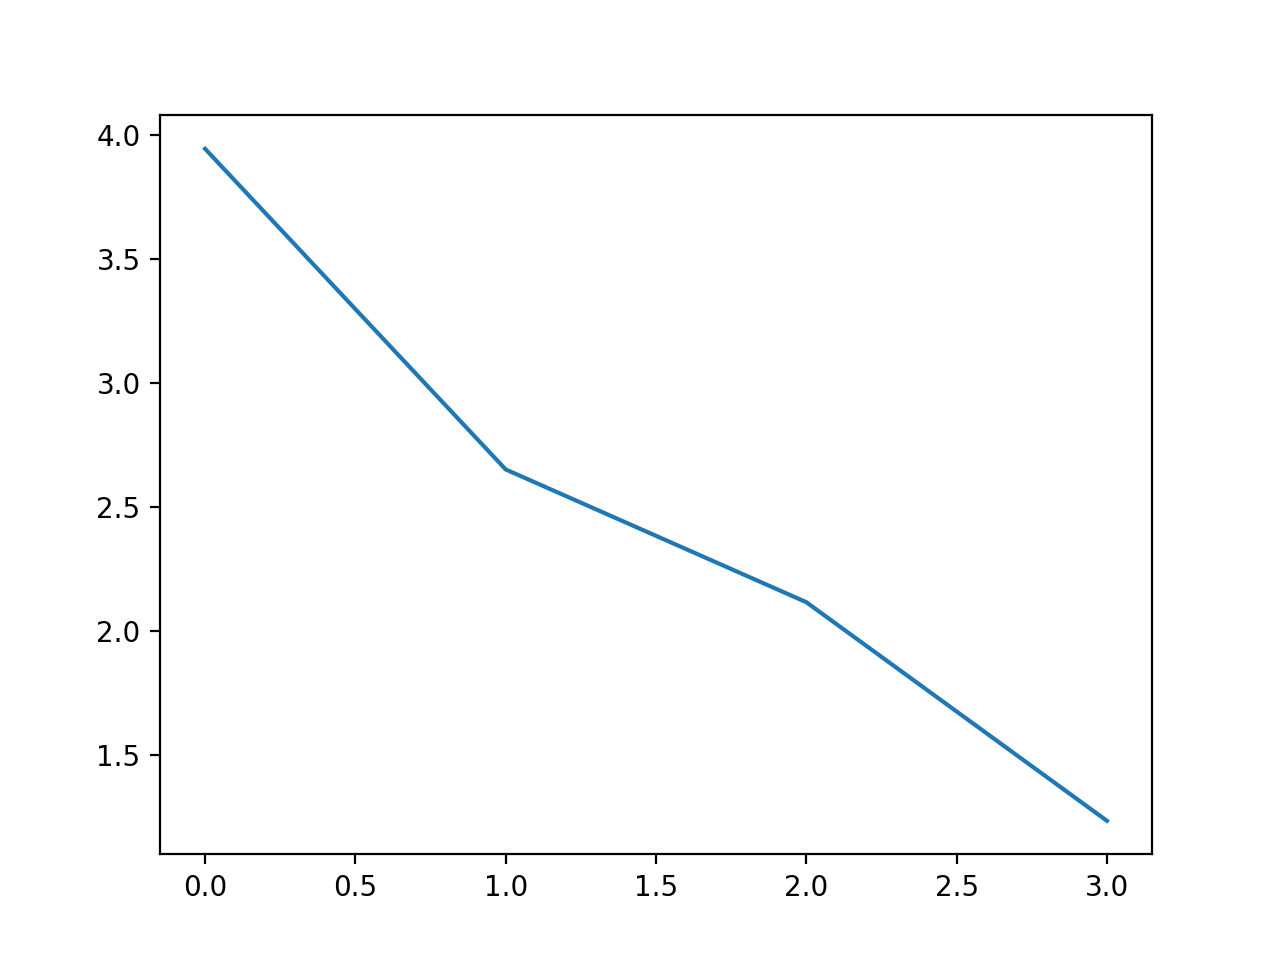

In [57]:
%matplotlib notebook
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [58]:
get_accuracy(test_loader,rnn_net)

Accuracy of the network:   43.47826086956522


**Вывод: при уменьшении количества кадров качество (точность) падает**

2. число кадров=60

In [60]:
dataset = Skeleton_Dataset(file_path = "test_03_60.csv", frames_count=60, transform=normalize)

In [61]:
[len(dataset),int(0.7*len(dataset)),int(0.3*len(dataset))]

[944, 660, 283]

In [62]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.7*len(dataset)),int(0.3*len(dataset))+1])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [63]:
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=8, bias=True)
)

In [64]:
skel, lab = dataset.__getitem__(41)
print(type(skel))
print(LABELS[lab])
print(skel.shape)

<class 'numpy.ndarray'>
take off a hat/cap
(60, 75)


In [65]:
sket_tensor = torch.from_numpy(skel).unsqueeze(0).float()
print(sket_tensor.size())
output = rnn(sket_tensor.to(device))
output.topk(5)

torch.Size([1, 60, 75])


torch.return_types.topk(
values=tensor([[ 0.1162,  0.0650, -0.0188, -0.0501, -0.0548]], grad_fn=<TopkBackward>),
indices=tensor([[3, 4, 0, 1, 2]]))

In [66]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)
epochs=200

In [67]:
rnn_net,all_losses=train_model(criterion, learning_rate, optimizer, rnn, train_loader,epochs)

epoch : 0 iter : 0 (0m 0s) 2.0610  предсказанное значение: take off a hat/cap ✗ (cheer up)
epoch : 11 iter : 38 (2m 33s) 1.7822  предсказанное значение: make a phone call/answer phone ✗ (hand waving)
epoch : 23 iter : 34 (5m 5s) 1.4691  предсказанное значение: make a phone call/answer phone ✓
epoch : 35 iter : 30 (7m 39s) 1.2313  предсказанное значение: cheer up ✗ (clapping)
epoch : 47 iter : 26 (10m 12s) 1.1261  предсказанное значение: make a phone call/answer phone ✓
epoch : 59 iter : 22 (12m 46s) 3.7236  предсказанное значение: make a phone call/answer phone ✗ (take off a shoe)
epoch : 71 iter : 18 (15m 21s) 1.4505  предсказанное значение: make a phone call/answer phone ✗ (take off a hat/cap)
epoch : 83 iter : 14 (18m 0s) 1.4537  предсказанное значение: make a phone call/answer phone ✓
epoch : 95 iter : 10 (20m 41s) 0.6768  предсказанное значение: cheer up ✗ (jump up)
epoch : 107 iter : 6 (23m 23s) 1.0073  предсказанное значение: cheer up ✗ (hand waving)
epoch : 119 iter : 2 (26m 6s

<IPython.core.display.Javascript object>


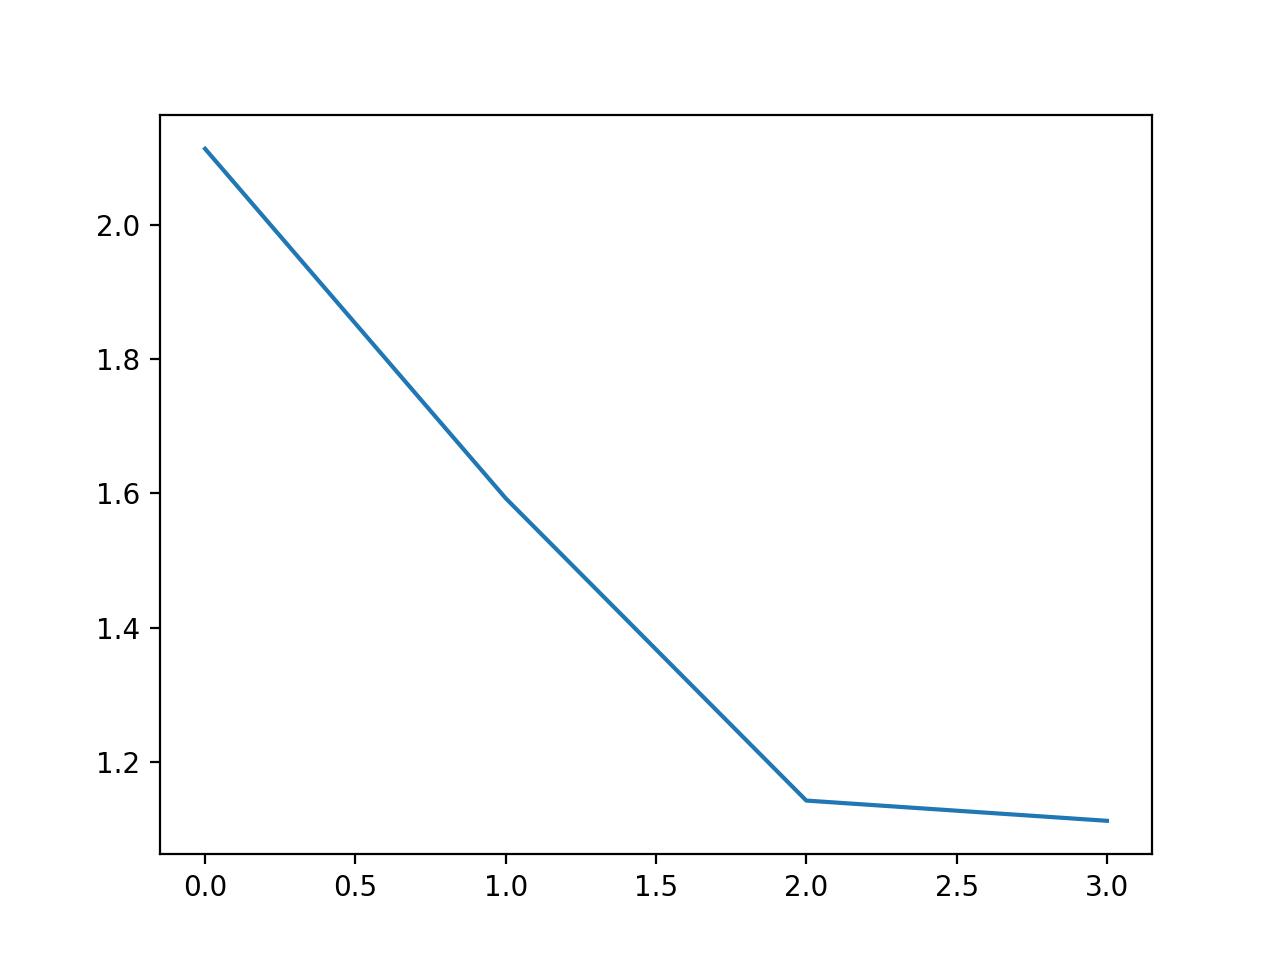

In [72]:
%matplotlib notebook
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [73]:
get_accuracy(test_loader,rnn_net)

Accuracy of the network:   77.77777777777777


**Вывод: при увеличении количества кадров качество (точность) возрастает**

**Оптимальное количество с учетом продолжительности вычислений где то 50-60 кадров**